# Predictive Maintenance for Machines

Develop a machine learning model to predict potential failures in industrial equipment based on sensor data and operational parameters. This project utilizes a synthetic dataset that mimics real-world predictive maintenance scenarios, focusing on early fault detection to minimize downtime and maintenance costs.

Import the necessary libararies for the project

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Step 1: Understand the Dataset
__The dataset includes features such as:__

1. Air temperature
2. Process temperature
3. Rotational speed
4. Torque
5. Tool wear
6. Failure type (target variable).

__We'll analyze it for:__

1. Data distribution.
2. Correlations between features and failure types.
3. Missing data and inconsistencies.

In [4]:
# Load the dataset
file_path = 'predictive_maintenance.csv'  # Adjust the path if needed
data = pd.read_csv(file_path)

# Display basic information
print(data.info())
print(data.describe(include='all'))

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Check for duplicates
print(f"Number of duplicate rows: {data.duplicated().sum()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None
                UDI Product ID   Type  Air temperature [K]  \
count   10000.00000      10000  10000         10000.000000   
unique          NaN      10000      3              

## Step 2: Data Exploration
__Load the dataset and:__

1. Display basic information (.info() and .describe()).
2. Check for missing values or duplicates.
3. Understand class imbalance for the target variable.

In [6]:
# Encode categorical variables
label_encoder_type = LabelEncoder()
label_encoder_failure = LabelEncoder()
data['Type_encoded'] = label_encoder_type.fit_transform(data['Type'])
data['Failure_Type_encoded'] = label_encoder_failure.fit_transform(data['Failure Type'])

# Verify encoding
print("Sample of encoded columns:")
print(data[['Type', 'Type_encoded', 'Failure Type', 'Failure_Type_encoded']].head())


Sample of encoded columns:
  Type  Type_encoded Failure Type  Failure_Type_encoded
0    M             2   No Failure                     1
1    L             1   No Failure                     1
2    L             1   No Failure                     1
3    L             1   No Failure                     1
4    L             1   No Failure                     1


In [8]:
# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
                      'Torque [Nm]', 'Tool wear [min]']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Check the transformed features
print("Normalized numerical features:")
print(data[numerical_features].head())


Normalized numerical features:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.304348                 0.358025                0.222934   
1             0.315217                 0.370370                0.139697   
2             0.304348                 0.345679                0.192084   
3             0.315217                 0.358025                0.154249   
4             0.315217                 0.370370                0.139697   

   Torque [Nm]  Tool wear [min]  
0     0.535714         0.000000  
1     0.583791         0.011858  
2     0.626374         0.019763  
3     0.490385         0.027668  
4     0.497253         0.035573  


Target distribution:
Target
0    9661
1     339
Name: count, dtype: int64


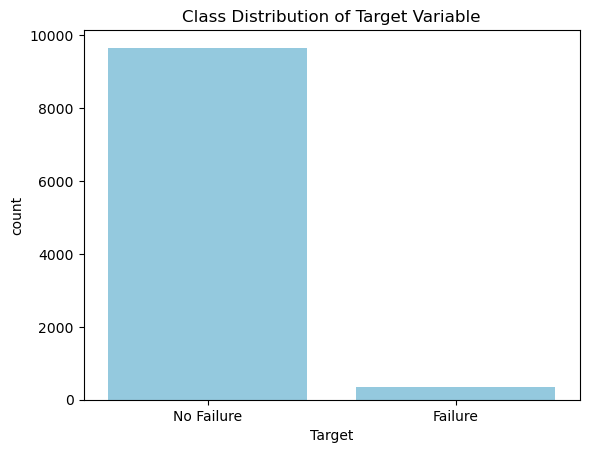

In [20]:
# Check class distribution
print("Target distribution:")
print(data['Target'].value_counts())

# Visualize class distribution
sns.countplot(data=data, x='Target', color="skyblue")
plt.title("Class Distribution of Target Variable")
plt.xticks(ticks=[0, 1], labels=["No Failure", "Failure"])
plt.show()


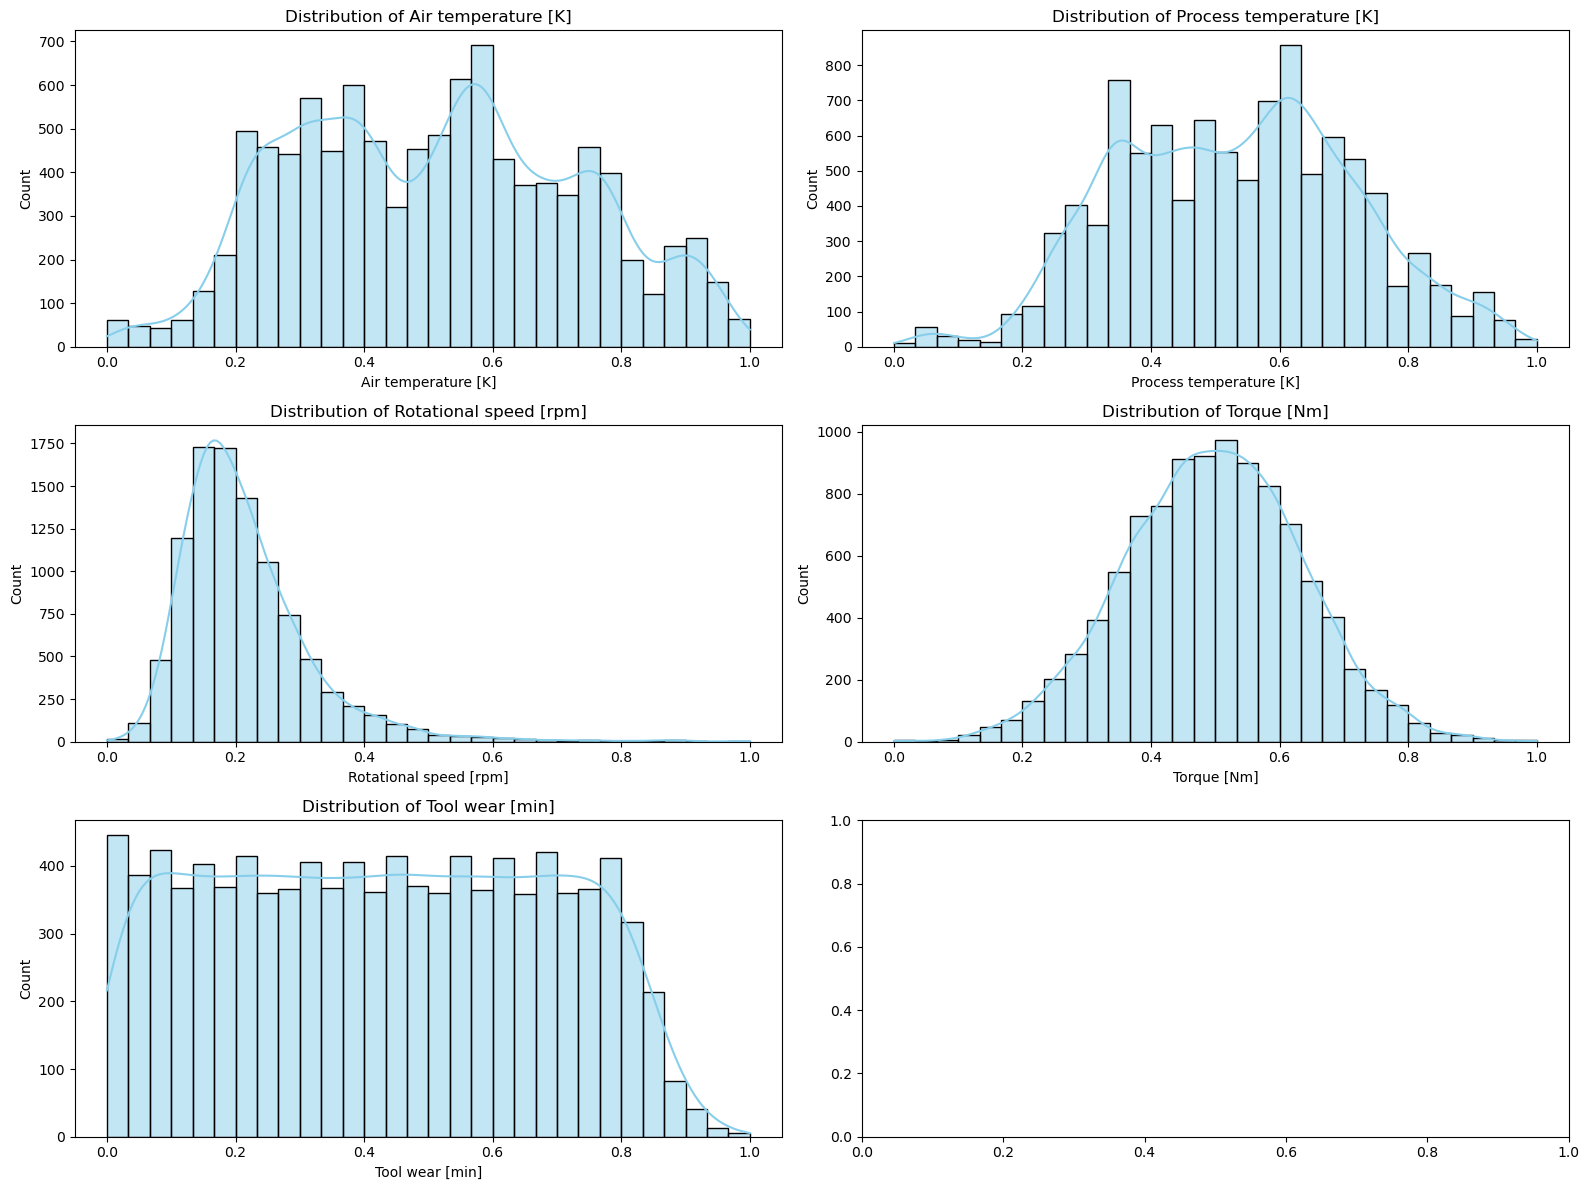

In [12]:
# Plot the distribution of numerical features
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i], color="skyblue")
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


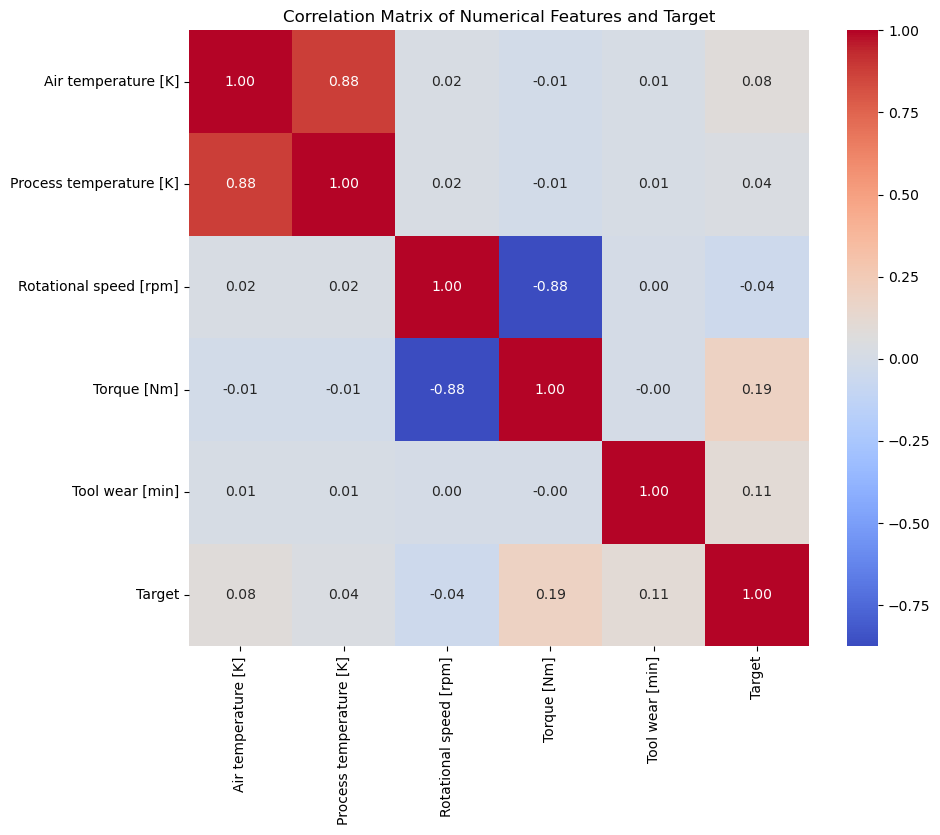

In [14]:
# Compute correlation matrix
correlation_matrix = data[numerical_features + ['Target']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features and Target")
plt.show()


In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features and target
X = data[numerical_features + ['Type_encoded', 'Failure_Type_encoded']]
y = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
from collections import Counter
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))


Original class distribution: Counter({0: 7729, 1: 271})
Resampled class distribution: Counter({0: 7729, 1: 7729})


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       0.97      0.97      0.97        68

    accuracy                           1.00      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC Score: 0.9891418523931311


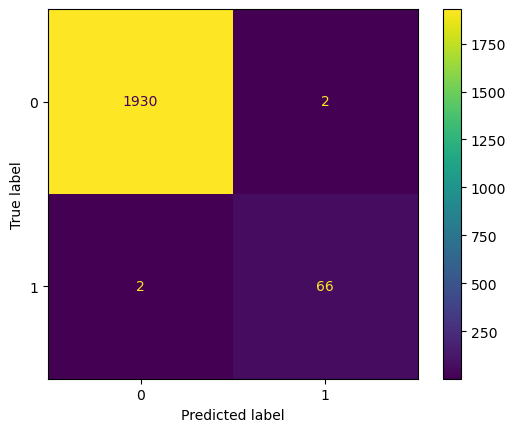

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [33]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END .max_depth=10, min_samples_split=5, n_e

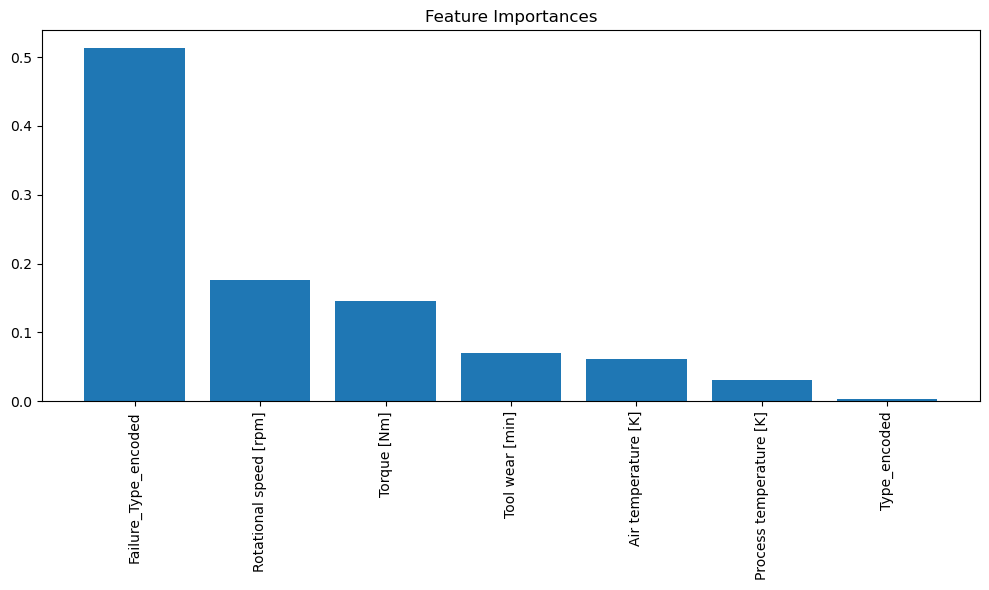

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance from the trained model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [43]:
# Clean feature names by removing unwanted characters
X_train_resampled.columns = [col.replace(' ', '_').replace('[', '').replace(']', '') for col in X_train_resampled.columns]
X_test.columns = [col.replace(' ', '_').replace('[', '').replace(']', '') for col in X_test.columns]

# Now, train the XGBoost model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb}")



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       0.97      0.97      0.97        68

    accuracy                           1.00      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC Score: 0.9815719766167338


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


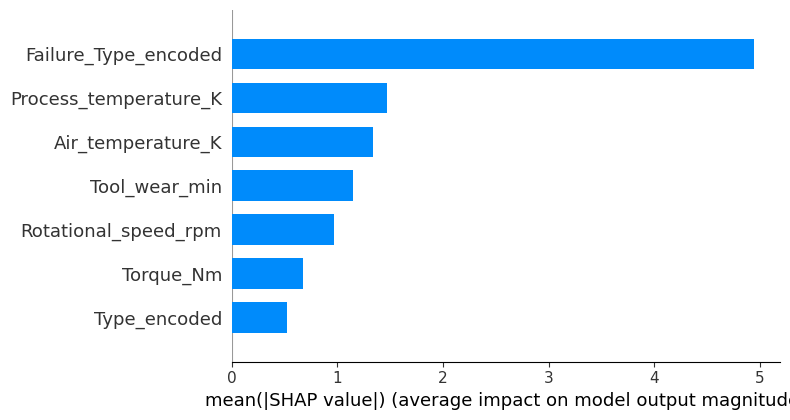

In [51]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the entire model (for binary classification, there will be two classes)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP summary plot (using the shap_values matrix)
shap.summary_plot(shap_values, X_test, plot_type="bar")



In [55]:
# Create rolling mean and standard deviation features
data['Torque_rolling_mean'] = data['Torque [Nm]'].rolling(window=5).mean()
data['Torque_rolling_std'] = data['Torque [Nm]'].rolling(window=5).std()
data['Torque_rolling_mean']
data['Torque_rolling_std']

0            NaN
1            NaN
2            NaN
3            NaN
4       0.058010
          ...   
9995    0.123588
9996    0.110688
9997    0.106300
9998    0.113411
9999    0.106007
Name: Torque_rolling_std, Length: 10000, dtype: float64